In [24]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import libraries
from fastai.imports import *

In [27]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [56]:
# Set data path
PATH = '../data/dogscats/'

In [29]:
# set size of images
sz = 224

In [57]:
# Look at pictures
!ls {PATH}

models	sample	test1  tmp  train  valid


In [58]:
!ls {PATH}valid

cats  dogs


In [59]:
files = !ls {PATH}/valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

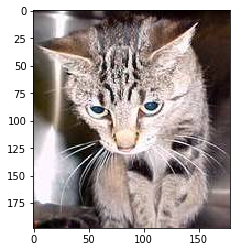

In [60]:
# See example of data
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [39]:
# Raw data
img.shape

(198, 179, 3)

In [37]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [40]:
# remove precomputed activations
!rm -rf {PATH}tmp

In [61]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [43]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


A Jupyter Widget

[ 0.       0.03884  0.02785  0.98682]                         
[ 1.       0.03538  0.02644  0.98828]                         
[ 2.       0.03468  0.02576  0.99023]                         



In [72]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [73]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [74]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [75]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

Correctly classified


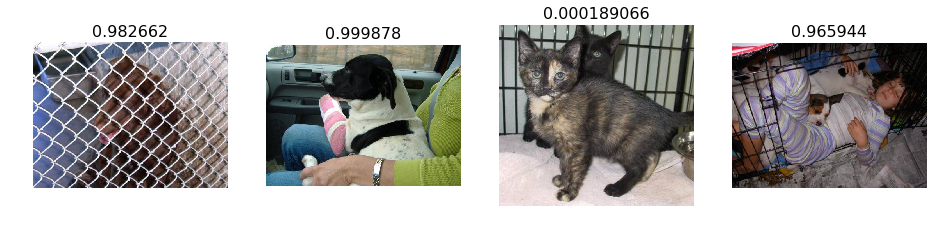

In [76]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


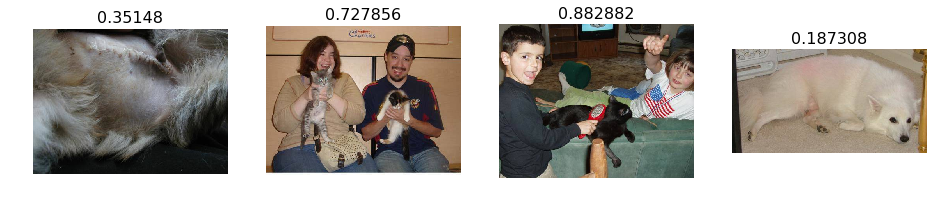

In [77]:
# Incorrect labels
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [78]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


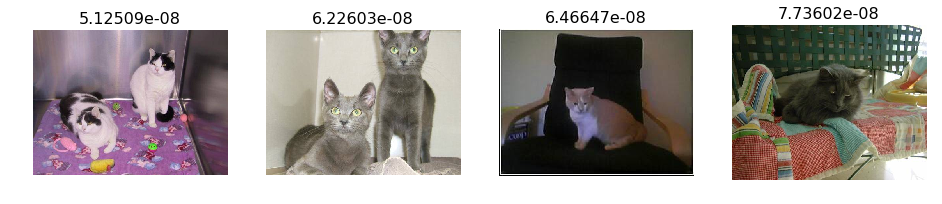

In [79]:
# Correct cats
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


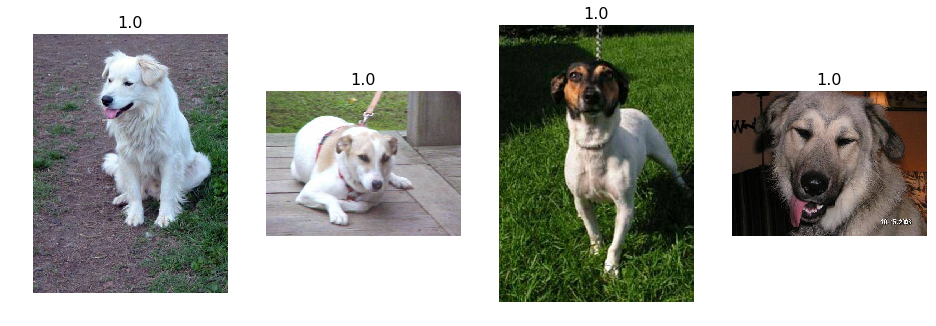

In [80]:
# correct dogs
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [81]:
# Choosing a learning rate
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

A Jupyter Widget

 80%|███████▉  | 287/360 [00:04<00:01, 57.88it/s, loss=0.38]  


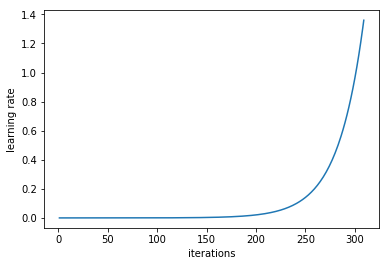

In [82]:
learn.sched.plot_lr()

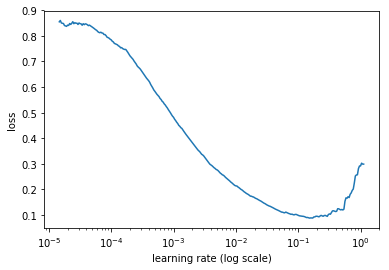

In [83]:
learn.sched.plot()

In [84]:
# Data Augmentation
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [86]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [87]:
ims = np.stack([get_augs() for i in range(6)])

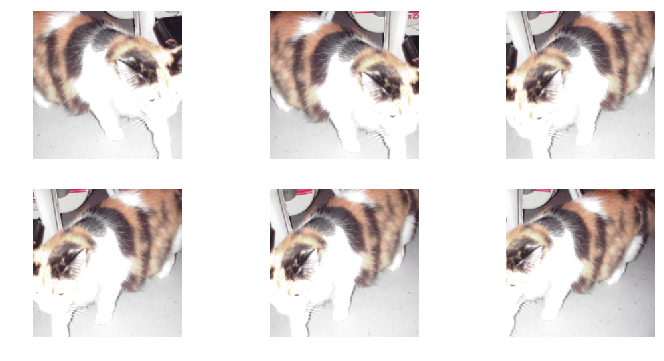

In [89]:
plots(ims, rows=2)

In [90]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [91]:
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.       0.04417  0.02522  0.99121]                         



In [92]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [93]:
# all but last layer frozen
learn.precompute = False

In [94]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.04648  0.02757  0.98877]                         
[ 1.       0.04938  0.02697  0.98975]                         
[ 2.       0.04344  0.02651  0.98877]                         



In [95]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

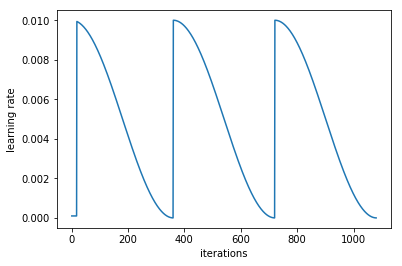

In [96]:
learn.schededed.plot_lr()

In [97]:
learn.save('224_lastlayer')

In [98]:
learn.load('224_lastlayer')

In [105]:
!ls {PATH}models

224_all.h5  224_lastlayer.h5  tmp.h5


In [106]:
# Fine-tuning and Differential Learning
# unfreeze all layers of the model
learn.unfreeze()

In [107]:
# earlier layers need less fine tuning, so have lower LR for them
lr = np.array([1e-4, 1e-3, 1e-2])

In [108]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.0486   0.02298  0.99268]                         
[ 1.       0.0378   0.02196  0.98877]                         
[ 2.       0.02813  0.0199   0.9917 ]                         
[ 3.       0.02917  0.01933  0.9917 ]                         
[ 4.       0.02554  0.01676  0.99365]                         
[ 5.       0.02167  0.01747  0.99268]                         
[ 6.       0.02591  0.01956  0.99268]                         



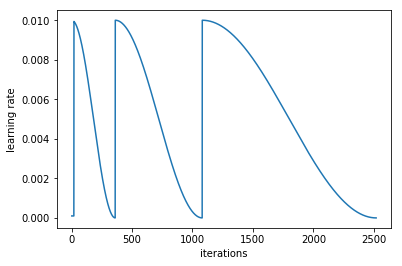

In [109]:
learn.sched.plot_lr()

In [110]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

In [111]:
learn.save('224_all')

In [112]:
learn.load('224_all')

In [113]:
# Data augmentation at inference time
log_preds, y = learn.TTA()
accuracy(log_preds,y)

0.99450000000000005